# Running example: Marginalizing over point source contamination or masking it

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
import scipy.stats as ss
from copy import deepcopy

In [2]:
import sys
sys.path.append("../..")
import panco2 as p2

This presents the pressure profile extraction from the NIKA2 map of the C2 cluster, presented in the validation paper.
The C2 cluster is a mock source with $z=0.5, \; M_{500} = 6 \times 10^{14} M_\odot$, with an Arnaud et al. (2010) universal pressure profile.
The NIKA2 map is projected using a gnomonic projection in (RA, dec), on a $6.5'$ square, with $3''$ pixels.
The noise is white, with an RMS map taken from NIKA2 ACTJ0215 observations.
The beam is Gaussian with $18''$ FWHM, and we use a smoothed version of the transfer function of Kéruzoré et al. (2020).

We also add two point sources S1 and S2, each with a $1 \; {\rm mJy}$ flux, respectively located at $30''$ and $75''$ from the cluster center.
The map used is the same as in the validation paper.

## Initialization

Start by reading in the data, giving cluster info, and the size and center of the map to be considered for the fit:

In [3]:
path = "."
ppf = p2.PressureProfileFitter(
    f"{path}/input_map.fits",
    1, 5,
    0.5, 6e14,
    map_size=6.5,
    coords_center=SkyCoord("12h00m00s +00d00m00s")
)

Then we define the radial binning to be used for the fit.
The first bin is defined as the projected radius corresponding to the size of a map pixel, $R_0 = \mathcal{D}_{\rm A}(z) \tan^{-1} \theta_{\rm pix}$, where $\mathcal{D}_{\rm A}(z)$ is the angular diameter distance to the cluster redshift $z$.
Four bins $\left\{R_1 \dots R_4 \right\}$ are then added, log-spaced between the projected sizes of the beam FWHM, $\mathcal{D}_{\rm A}(z) \tan^{-1} \theta_{\rm FWHM}$, and of the half map size, $\mathcal{D}_{\rm A}(z) \tan^{-1} \theta_{\rm map} / 2$.

In [4]:
pix_kpc, half_map_kpc = ppf.cluster.arcsec2kpc(ppf.pix_size), ppf.cluster.arcsec2kpc(ppf.map_size * 60 / 2)
beam_kpc = ppf.cluster.arcsec2kpc(18.0)
r_bins = np.concatenate(([pix_kpc], np.logspace(np.log10(beam_kpc), np.log10(1.1 * half_map_kpc), 4)))

ppf.define_model(r_bins)


Add filtering: $18''$ beam, NIKA2-like transfer function

In [5]:
tf = np.load(f"{path}/nk2_tf.npz")
ppf.add_filtering(beam_fwhm=18.0, ell=tf["ell"], tf=tf["tf_150GHz"], pad=20)
ppf2 = deepcopy(ppf)  # for later

==> Adding filtering: beam and 1D transfer function


## Joint fit of the tSZ model and point sources

``panco2`` offers the possibility to perform a joint fit of the tSZ map and of the point source contamination.
In this framework, 2D point source models are added at fixed positions to the model map created in the forward modeling.
The flux of each source is treated as a parameter of the fit, with a prior to be defined by the user.
This enables the propagation of the uncertainty on the fluxes of each source to the final results.

To do that, we need to initialize the point source model by giving the ``PressureProfileFitter`` object the position of each source, and the FWHM of the Gaussian model (i.e. the map resolution):

In [6]:
ps_pos = [
    SkyCoord("12h00m00s +00d00m30s"),
    SkyCoord("12h00m05s +00d00m10s"),
]
ppf.add_point_sources(ps_pos, 18.0)

==> Adding 2 point sources


Priors: log-uniform centered on A10 values for pressure bins, Gaussian for the conversion and zero-level.
For the sources, we add a Gaussian prior $\mathcal{N}(1, 0.2) \; {\rm mJy/beam}$ and a uniform prior $\mathcal{U}(0, 2) \; {\rm mJy/beam}$ on 

In [7]:
P_bins = p2.utils.gNFW(r_bins, *ppf.cluster.A10_params)
ppf.define_priors(
    P_bins=[ss.loguniform(0.01 * P, 100.0 * P) for P in P_bins],
    conv=ss.norm(-12.0, 1.2),
    zero=ss.norm(0.0, 1e-4),
    ps_fluxes=[ss.norm(1e-3, 2e-4), ss.uniform(0.0, 2e-3)]
)

Run the MCMC:

In [8]:
# np.random.seed(42)
# _ = ppf.run_mcmc(
#     30, 5e4, 4, n_check=5e2, max_delta_tau=0.01, min_autocorr_times=100, 
#     out_chains_file=f"{path}/raw_chains_psfit.npz", plot_convergence=f"{path}/mcmc_convergence.pdf"
# )

Clean up the raw chains:

In [9]:
chains_clean = p2.results.load_chains(f"{path}/raw_chains_psfit.npz", 500, 50, clip_percent=20.0, verbose=True)

Raw length: 7000, clip 500 as burn-in, discard 49/50 samples  -> Final chains length: 130
30 walkers, remove chains with the 20.0% most extreme values  -> 30 chains remaining
-> Final sampling size: 30 chains * 130 samples per chain = 3900 total samples


Plot everything:

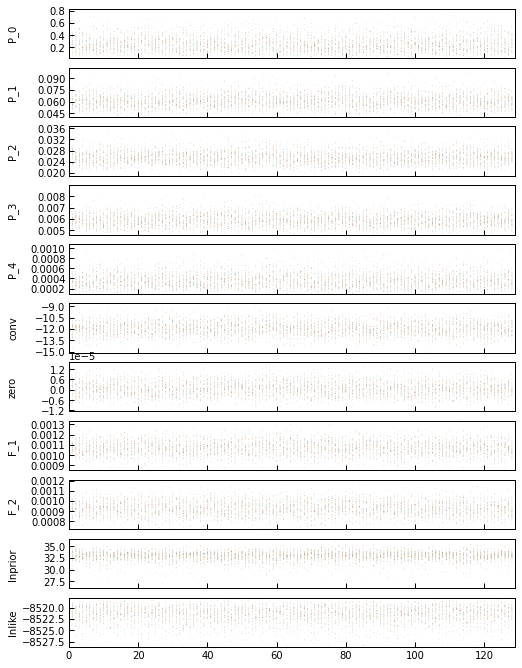

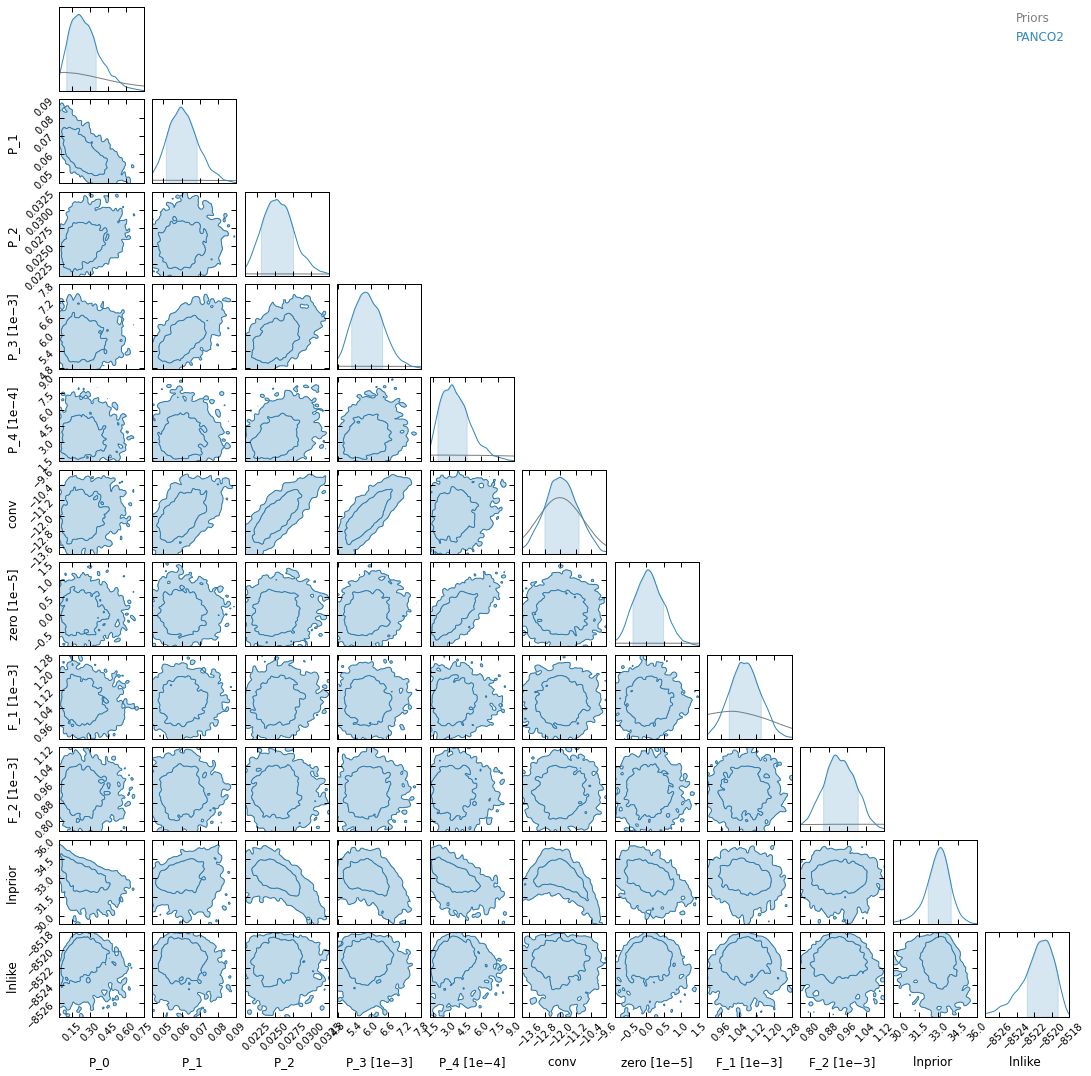

In [10]:
plt.close("all")
_ = p2.results.mcmc_trace_plot(chains_clean, filename=f"{path}/mcmc_trace_psfit.png")
_ = p2.results.mcmc_corner_plot(chains_clean, ppf=ppf, filename=f"{path}/mcmc_corner_psfit.pdf")

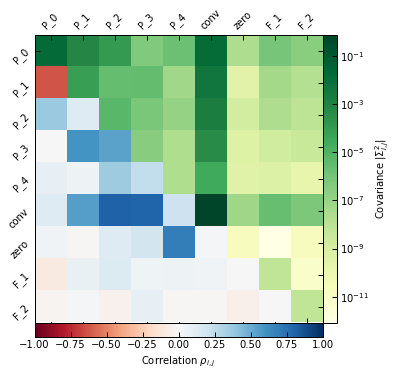

In [11]:
_ = p2.results.mcmc_matrices_plot(chains_clean, ppf, filename=f"{path}/mcmc_matrices_psfit.pdf")

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$\\theta \\; [{\\rm arcsec}]$', ylabel='NIKA2 150 GHz [mJy/beam]'>)

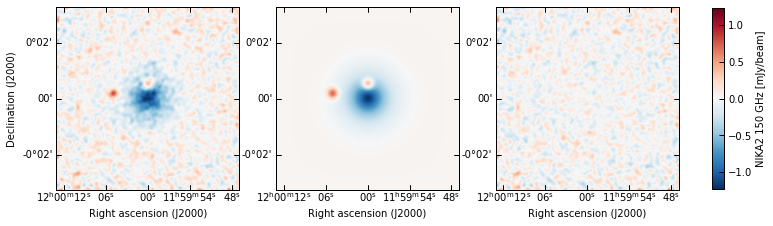

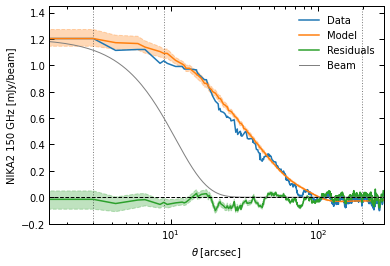

In [12]:
meds = dict(chains_clean.median())
p2.results.plot_data_model_residuals(
    ppf, par_dic=meds, smooth=1.0, cbar_fact=1e3, cmap="RdBu_r", lims="sym",
    cbar_label="NIKA2 150 GHz [mJy/beam]", filename=f"{path}/data_model_residuals_maps_psfit.pdf"
)
p2.results.plot_data_model_residuals_1d(
    ppf, chains_clean=chains_clean, y_fact=-1e3, plot_beam=True, 
    y_label="NIKA2 150 GHz [mJy/beam]", filename=f"{path}/data_model_residuals_profiles_psfit.pdf", x_log=True
)

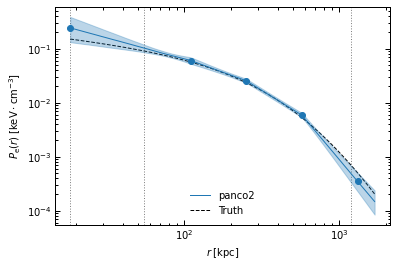

In [13]:
r_range = np.logspace(np.log10(ppf.cluster.arcsec2kpc(ppf.pix_size)), np.log10(ppf.cluster.arcsec2kpc(ppf.map_size * 60 / np.sqrt(2))), 100)
fig, ax = p2.results.plot_profile(chains_clean, ppf, r_range=r_range, label="panco2", color="tab:blue")
ax.plot(r_range, p2.utils.gNFW(r_range, *ppf.cluster.A10_params), "k--", label="Truth")
ax.legend(frameon=False)
fig.savefig(f"{path}/pressure_profile_psfit.pdf")

## Masking point sources

Alternatively, if one knows little about the point source fluxes, it may be useful to mask them.
The ``panco2.masks`` module can be used to create a mask discarding a circular patch around the position of each source:

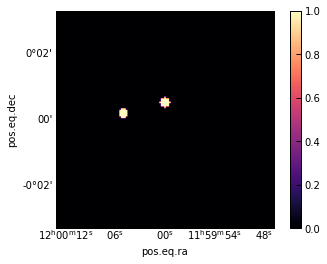

In [14]:
mask = p2.masks.mask_holes(ppf2, ps_pos, (18.01 / 2.0) / ppf2.pix_size)
fig = plt.figure()
ax = fig.add_subplot(111, projection=ppf2.wcs)
im = ax.imshow(mask.astype(float), vmin=0, vmax=1, cmap="magma")
fig.colorbar(im, ax=ax)

Note that the boolean mask is counter-intuitive -- it is True where the pixels *are masked*.
This is for compatibility with ``numpy.ma.MaskedArray``.

Once the mask is created, it can be added to the ``PressureProfileFitter`` object:

In [15]:
ppf2.add_mask(mask)

==> Adding mask
    Masking 55 / 17161 pixels


Add the priors, same as before, but this time without the point source fluxes:

In [16]:
P_bins = p2.utils.gNFW(r_bins, *ppf2.cluster.A10_params)
ppf2.define_priors(
    P_bins=[ss.loguniform(0.01 * P, 100.0 * P) for P in P_bins],
    conv=ss.norm(-12.0, 1.2),
    zero=ss.norm(0.0, 1e-4),
)

Run the MCMC:

In [17]:
# np.random.seed(42)
# _ = ppf2.run_mcmc(
#     30, 5e4, 4, n_check=5e2, max_delta_tau=0.01, min_autocorr_times=100, 
#     out_chains_file=f"{path}/raw_chains_psmsk.npz", plot_convergence=f"{path}/mcmc_convergence.pdf"
# )

Clean up the raw chains:

In [18]:
chains_clean = p2.results.load_chains(f"{path}/raw_chains_psmsk.npz", 500, 50, clip_percent=20.0, verbose=True)

Raw length: 7000, clip 500 as burn-in, discard 49/50 samples  -> Final chains length: 130
30 walkers, remove chains with the 20.0% most extreme values  -> 30 chains remaining
-> Final sampling size: 30 chains * 130 samples per chain = 3900 total samples


Plot everything:

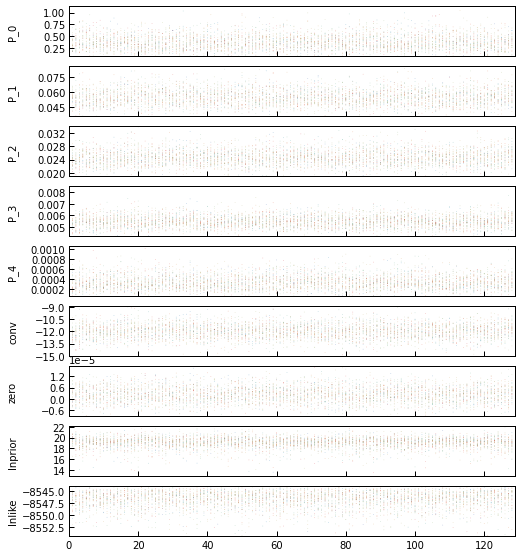

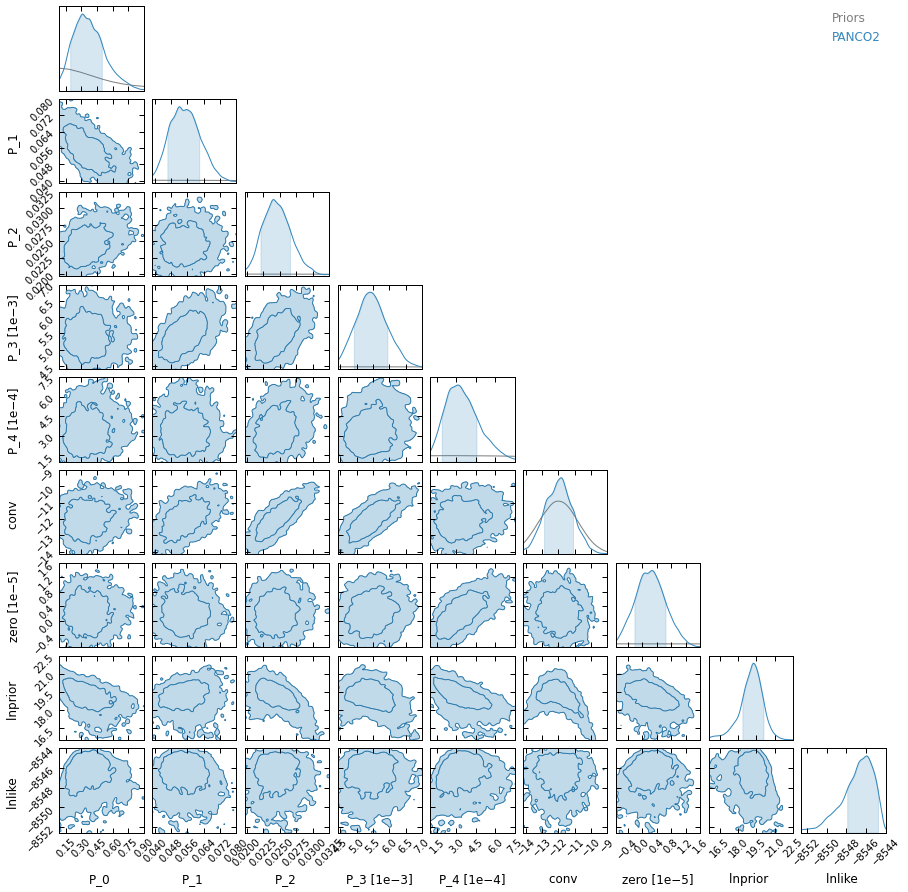

In [19]:
plt.close("all")
_ = p2.results.mcmc_trace_plot(chains_clean, filename=f"{path}/mcmc_trace_psmsk.png")
_ = p2.results.mcmc_corner_plot(chains_clean, ppf=ppf2, filename=f"{path}/mcmc_corner_psmsk.pdf")

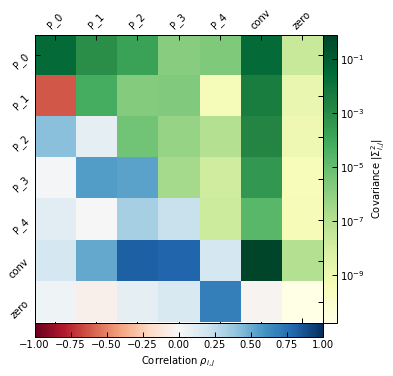

In [20]:
_ = p2.results.mcmc_matrices_plot(chains_clean, ppf2, filename=f"{path}/mcmc_matrices_psmsk.pdf")

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$\\theta \\; [{\\rm arcsec}]$', ylabel='NIKA2 150 GHz [mJy/beam]'>)

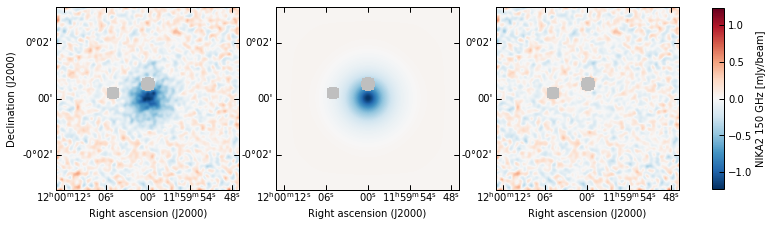

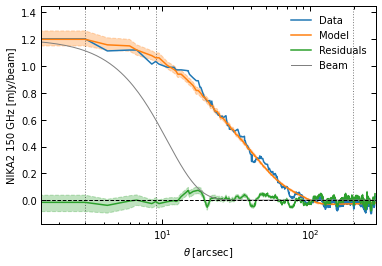

In [21]:
meds = dict(chains_clean.median())
p2.results.plot_data_model_residuals(
    ppf2, par_dic=meds, smooth=1.0, cbar_fact=1e3, cmap="RdBu_r", lims="sym",
    cbar_label="NIKA2 150 GHz [mJy/beam]", filename=f"{path}/data_model_residuals_maps_psmsk.pdf"
)
p2.results.plot_data_model_residuals_1d(
    ppf2, chains_clean=chains_clean, y_fact=-1e3, plot_beam=True, 
    y_label="NIKA2 150 GHz [mJy/beam]", filename=f"{path}/data_model_residuals_profiles_psmsk.pdf", x_log=True
)

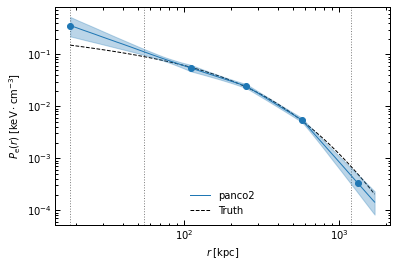

In [22]:
r_range = np.logspace(np.log10(ppf2.cluster.arcsec2kpc(ppf2.pix_size)), np.log10(ppf2.cluster.arcsec2kpc(ppf2.map_size * 60 / np.sqrt(2))), 100)
fig, ax = p2.results.plot_profile(chains_clean, ppf2, r_range=r_range, label="panco2", color="tab:blue")
ax.plot(r_range, p2.utils.gNFW(r_range, *ppf2.cluster.A10_params), "k--", label="Truth")
ax.legend(frameon=False)
fig.savefig(f"{path}/pressure_profile_psmsk.pdf")